## Import labraries

In [1]:
# =====================================
# Skin Cancer Prediction - HAM10000
# Binary Classification: Malignant vs Benign
# =====================================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## 2️⃣Load Dataset

In [2]:
df = pd.read_csv("ham10000_metadata.csv")
df = df.dropna()  # Drop missing values

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9958 entries, 0 to 10014
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lesion_id             9958 non-null   object 
 1   image_id              9958 non-null   object 
 2   dx                    9958 non-null   object 
 3   dx_type               9958 non-null   object 
 4   age                   9958 non-null   float64
 5   sex                   9958 non-null   int64  
 6   localization          9958 non-null   object 
 7   target                9958 non-null   int64  
 8   localization_encoded  9958 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 778.0+ KB


In [3]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [4]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


## Age Disrtribution

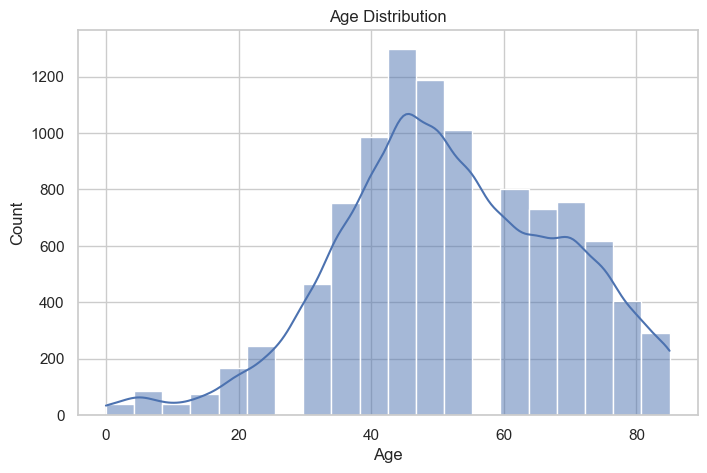

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], kde=True, bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

## Target and Benign/Malignant

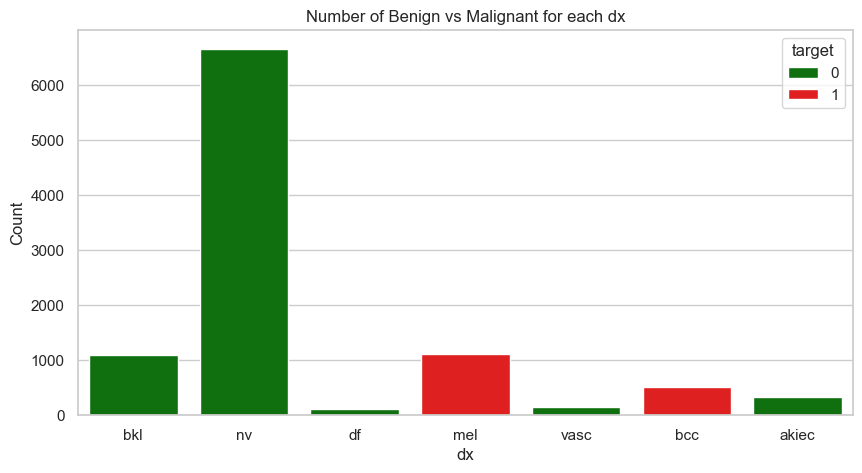

In [6]:
# تعریف کلاس‌های بدخیم صحیح
malignant_dx = ['mel', 'bcc']  # فقط Melanoma و Basal Cell Carcinoma

# ایجاد ستون target: 1=malignant, 0=benign
df['target'] = df['dx'].apply(lambda x: 1 if x in malignant_dx else 0)

# Countplot Benign vs Malignant
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='dx', hue='target', palette={0:'green', 1:'red'})
plt.title('Number of Benign vs Malignant for each dx')
plt.xlabel('dx')
plt.ylabel('Count')
plt.show()

## 4 Malignancy Rate per Lesion Type

C:\Users\Sayed niamatullah\AppData\Local\Temp\ipykernel_14368\2554421221.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=dx_stats.index, y=dx_stats['malignancy_rate'], palette=palette_colors)


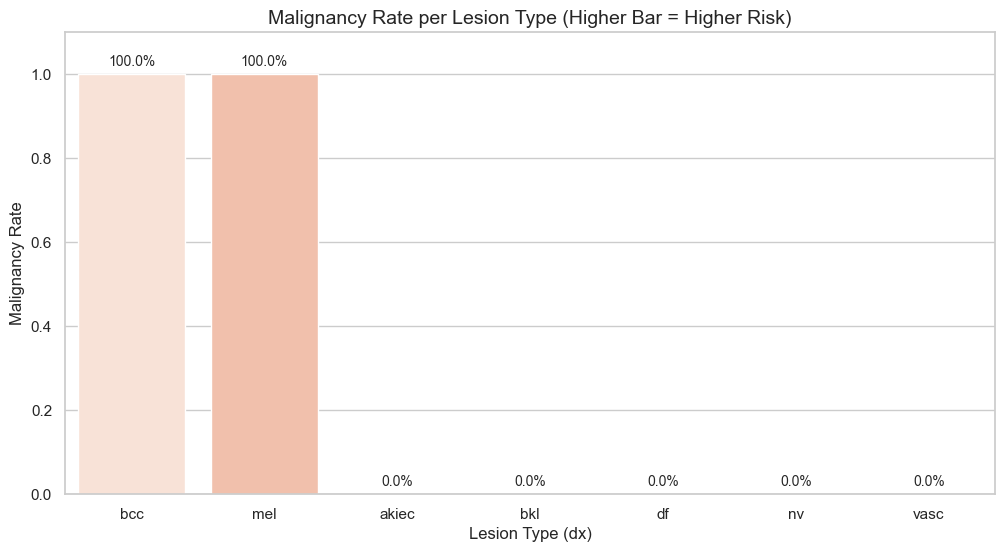

In [7]:
dx_stats = df.groupby('dx')['target'].agg(['sum','count'])
dx_stats['malignancy_rate'] = dx_stats['sum'] / dx_stats['count']
dx_stats = dx_stats.sort_values('malignancy_rate', ascending=False)

plt.figure(figsize=(12,6))
palette_colors = sns.color_palette("Reds", len(dx_stats))
ax = sns.barplot(x=dx_stats.index, y=dx_stats['malignancy_rate'], palette=palette_colors)

for i, rate in enumerate(dx_stats['malignancy_rate']):
    ax.text(i, rate + 0.02, f"{rate*100:.1f}%", ha='center', fontsize=10)

plt.ylabel('Malignancy Rate')
plt.xlabel('Lesion Type (dx)')
plt.title('Malignancy Rate per Lesion Type (Higher Bar = Higher Risk)', fontsize=14)
plt.ylim(0,1.1)
plt.show()

## Lable Encoding 

In [8]:
# 5️⃣ Label Encoding
# Encode categorical features
le_sex = LabelEncoder()
le_loc = LabelEncoder()

df['sex'] = le_sex.fit_transform(df['sex'].astype(str))
df['localization_encoded'] = le_loc.fit_transform(df['localization'].astype(str))

# Features و Target
X = df[['age', 'sex', 'localization_encoded']]  # فقط ویژگی‌های قابل استفاده برای User Input
y = df['target']  # Binary: 0=benign, 1=malignant

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape of training set:", X_train.shape)
print("Shape of test set:", X_test.shape)

Shape of training set: (7966, 3)
Shape of test set: (1992, 3)


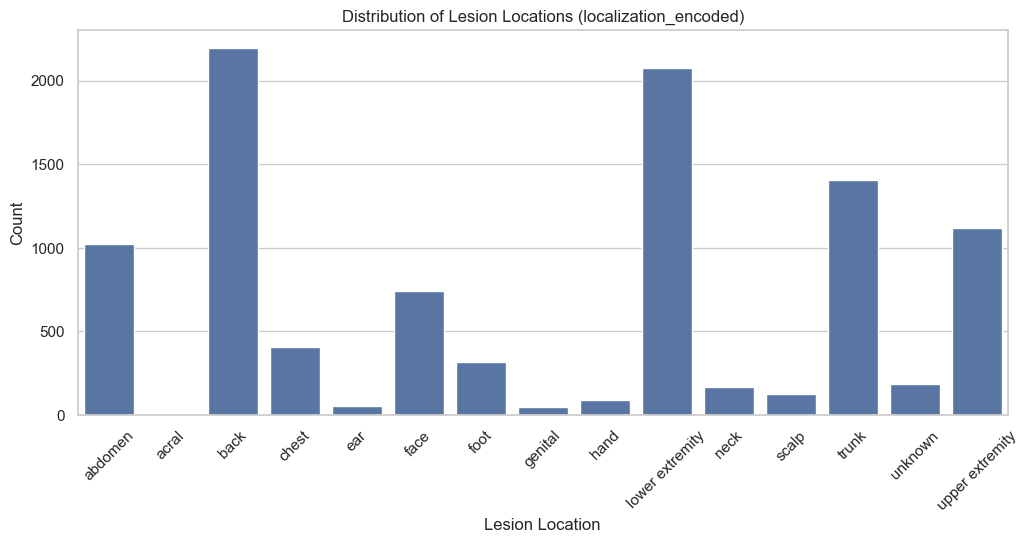

In [9]:
# نمایش تعداد نمونه‌ها در هر موقعیت ضایعه
loc_counts = df['localization_encoded'].value_counts().sort_index()
loc_labels = le_loc.inverse_transform(loc_counts.index)  # تبدیل عدد به متن

plt.figure(figsize=(12,5))
sns.barplot(x=loc_labels, y=loc_counts.values)
plt.title("Distribution of Lesion Locations (localization_encoded)")
plt.xlabel("Lesion Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

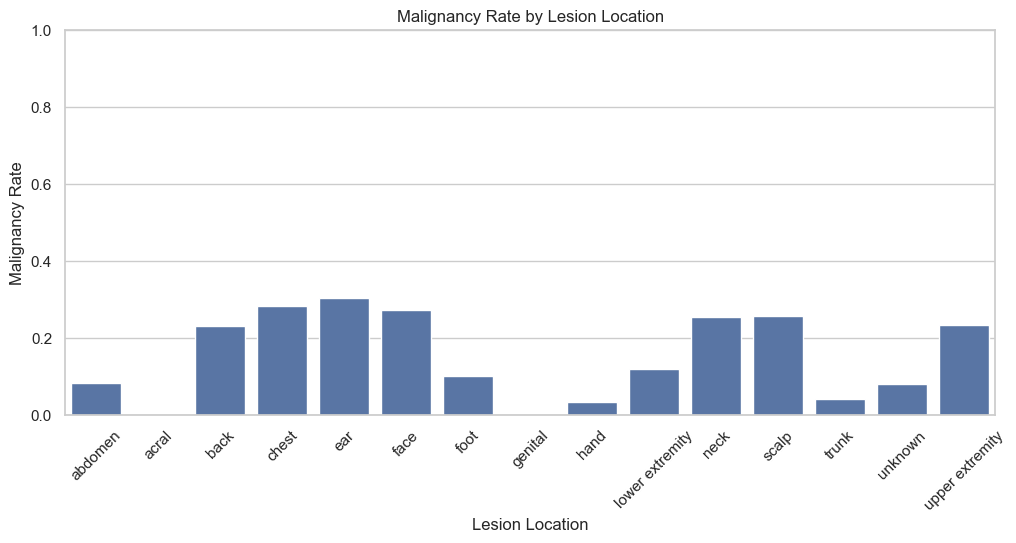

In [10]:
# محاسبه میانگین target (احتمال malignancy) برای هر موقعیت
loc_malignancy = df.groupby('localization_encoded')['target'].mean().sort_index()
loc_labels = le_loc.inverse_transform(loc_malignancy.index)

plt.figure(figsize=(12,5))
sns.barplot(x=loc_labels, y=loc_malignancy.values)
plt.title("Malignancy Rate by Lesion Location")
plt.xlabel("Lesion Location")
plt.ylabel("Malignancy Rate")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

## Train Random Forest and Evaluate Model

In [11]:
# 6️⃣ Train Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=200,          # تعداد درخت‌ها
    random_state=42,           # برای reproducibility
    class_weight='balanced'    # برای متعادل کردن کلاس‌های Malignant/Benign
)

# آموزش مدل
model.fit(X_train, y_train)

# پیش‌بینی روی داده تست
y_pred = model.predict(X_test)

# ارزیابی مدل
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7354417670682731

Confusion Matrix:
 [[1244  423]
 [ 104  221]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.83      1667
           1       0.34      0.68      0.46       325

    accuracy                           0.74      1992
   macro avg       0.63      0.71      0.64      1992
weighted avg       0.83      0.74      0.76      1992



## Feture Importance

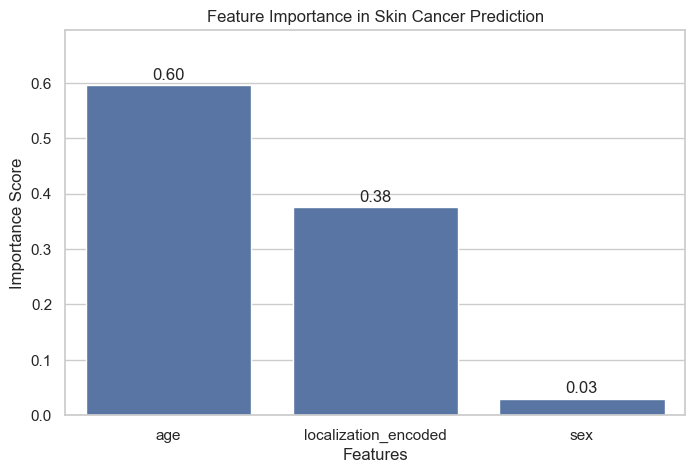

In [12]:
# 7️⃣ Feature Importance
feature_names = X.columns
importances = model.feature_importances_

# ایجاد DataFrame برای مرتب‌سازی بر اساس اهمیت
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# نمایش نمودار Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x='Feature', y='Importance')
plt.title("Feature Importance in Skin Cancer Prediction")
plt.ylabel("Importance Score")
plt.xlabel("Features")

# نمایش مقدار عددی بالای هر ستون
for index, row in imp_df.iterrows():
    plt.text(imp_df.index.get_loc(index), row['Importance'] + 0.01, f"{row['Importance']:.2f}", ha='center')

plt.ylim(0, imp_df['Importance'].max() + 0.1)
plt.show()

## User Input Prediction

In [14]:
# 8️⃣ User Input Prediction
print("\n===== Skin Cancer Risk Prediction =====")

# ------------------------------
# Gender
gender_options = ['male', 'female']
print("Gender options:", ', '.join(gender_options))
sex_input = input("Enter the gender: ").strip().lower()
sex_encoded = le_sex.transform([sex_input])[0]

# ------------------------------
# Lesion location
print("Available lesion locations:")
print(le_loc.classes_)
loc_input = input("Enter lesion location: ").strip().lower()
loc_encoded = le_loc.transform([loc_input])[0]

# ------------------------------
# Age
age_input = int(input("Enter the patient's age (e.g., 45): "))

# ------------------------------
# Create input DataFrame
user_df = pd.DataFrame(
    [[age_input, sex_encoded, loc_encoded]],
    columns=['age', 'sex', 'localization_encoded']
)

# ------------------------------
# Predict probability
prob = model.predict_proba(user_df)[0]

cancer_prob = prob[1]      # احتمال Malignant
no_cancer_prob = prob[0]   # احتمال Benign

# ------------------------------
# Display result
print("\n===== RESULT =====")
print(f"🔴 Probability of cancer: {cancer_prob*100:.1f}%")
print(f"🟢 Probability of no cancer: {no_cancer_prob*100:.1f}%")

if cancer_prob >= 0.5:
    print("⚠️ HIGH RISK: Immediate medical consultation recommended.")
else:
    print("✅ LOW RISK: Cancer probability appears low, but monitoring is advised.")


===== Skin Cancer Risk Prediction =====
Gender options: male, female


Enter the gender:  male


Available lesion locations:
['abdomen' 'acral' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'unknown' 'upper extremity']


Enter lesion location:  foot
Enter the patient's age (e.g., 45):  21



===== RESULT =====
🔴 Probability of cancer: 0.0%
🟢 Probability of no cancer: 100.0%
✅ LOW RISK: Cancer probability appears low, but monitoring is advised.
